In [2]:
import numpy as np 
import pandas as pd  
from matplotlib import pyplot as plt, ticker as mticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import re
import utils

In [3]:
df = pd.read_csv('../Datasets/titanic.csv')
print(df.shape)
df.head()

(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1047, 13), (1047,), (262, 13), (262,))

In [5]:
def preprocessing(X):

    # 1. Drop features that are not needed
    X = X.drop(columns=['ticket', 'fare', 'boat', 'body', 'home.dest'], axis=1)

    # 2. Make 'cabin' less granular and more meaningful
    X['cabin'] = [i[0] if pd.notna(i) else np.nan for i in X['cabin']]

    # 3. Create a new feature called "title" and drop the name column 
    pattern = r',\s*([A-Za-z]+)\.'
    X['title'] = X['name'].str.extract(pattern, expand=False)
    X = X.drop(['name'], axis=1)

    # 4. Transform 'pclass' from a numerical to a categorical feature
    X['pclass'] = X['pclass'].astype('str')

    return X

In [32]:
preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.transform(X_train)

In [6]:
df_missing = pd.DataFrame(X_train.isna().mean().sort_values(ascending=False), columns=['missing_pct'])
df_missing['dtype'] = [X_train[var].dtype for var in df_missing.index]
df_missing['exclude'] = [1 if i >= 0.2 else 0 for i in df_missing['missing_pct']]
df_missing

,missing_pct,dtype,exclude
cabin,0.776504,object,1
age,0.197708,float64,0
embarked,0.000955,object,0
title,0.000955,object,0
pclass,0.000000,object,0
sex,0.000000,object,0
sibsp,0.000000,int64,0
parch,0.000000,int64,0


In [7]:
variables_num = [var for var in X_train.columns if X_train[var].dtype != 'O']
variables_cat = [var for var in X_train.columns if var not in variables_num]

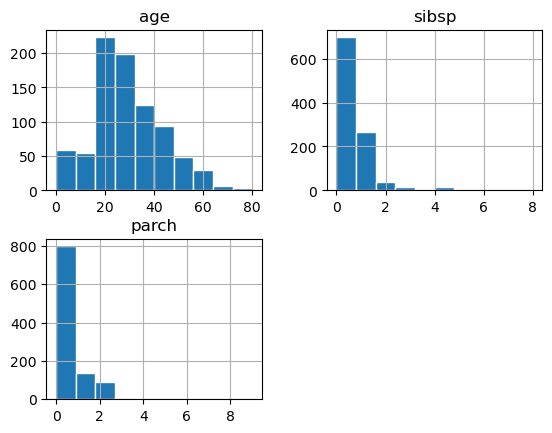

In [8]:
X_train[variables_num].hist(ec='white');

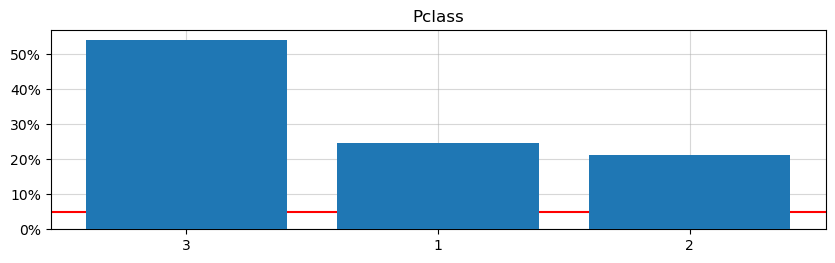

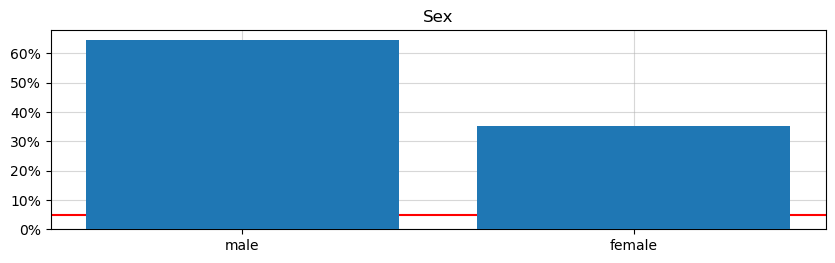

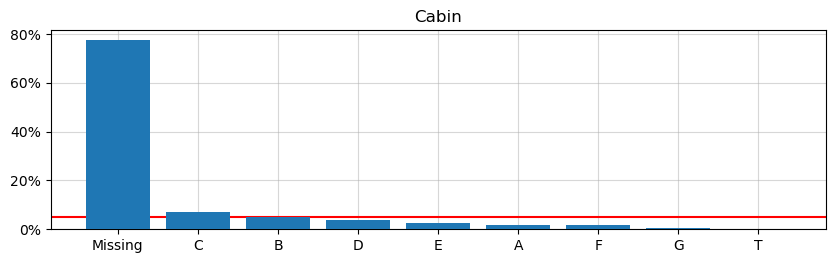

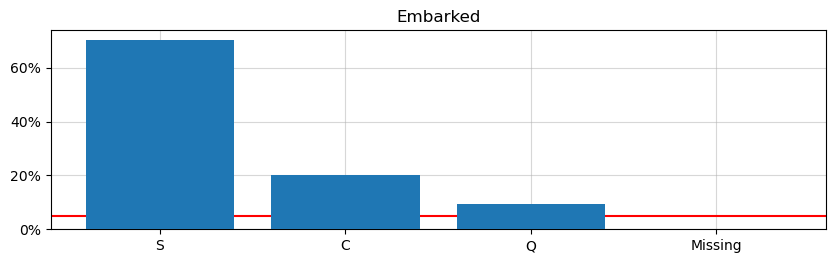

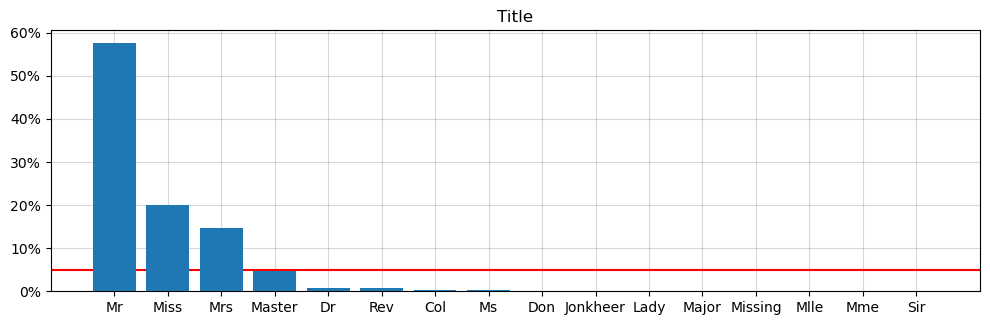

In [9]:
for i, var in enumerate(variables_cat):
    data = X_train.copy()
    data = data.fillna('Missing')
    data = pd.DataFrame(data.groupby(var, dropna=False)[var].count().sort_values(ascending=False) / data.shape[0])
    plt.figure(figsize=(10, len(variables_cat)*3))
    plt.subplot(len(variables_cat), 1, i+1)
    plt.bar(x=data.index.tolist(), height=data[var], zorder=5)
    plt.title(var.title())
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.axhline(y=0.05, color='red')
    plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
y_train.groupby(X_train['title']).mean().sort_values(ascending=False)

title
Lady        1.000000
Mlle        1.000000
Mme         1.000000
Sir         1.000000
Mrs         0.777778
Miss        0.661905
Col         0.500000
Dr          0.500000
Master      0.500000
Ms          0.500000
Mr          0.144040
Don         0.000000
Jonkheer    0.000000
Major       0.000000
Rev         0.000000
Name: survived, dtype: float64

### Encoding of categorical features: 
1. pclass  
2. sex  
3. embarked  
4. title  



## Optbinning 

### Load data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.3,
                                                    random_state=42)

### Preprocess X_train

In [27]:
preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.fit_transform(X_train)
X_train.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
1214,3,male,NaN,0,0,NaN,S,Mr
677,3,male,26.0,0,0,NaN,S,Mr
534,2,female,19.0,0,0,NaN,S,Miss
1174,3,female,NaN,8,2,NaN,S,Miss
864,3,female,28.0,0,0,NaN,S,Miss


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[3],507,0.553493,385,122,0.240631,0.579729,0.167854,0.020693
1,[2],182,0.198690,111,71,0.390110,-0.122643,0.003036,0.000379
2,[1],227,0.247817,89,138,0.607930,-1.008111,0.266929,0.032021
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,916,1.000000,585,331,0.361354,,0.437820,0.053094


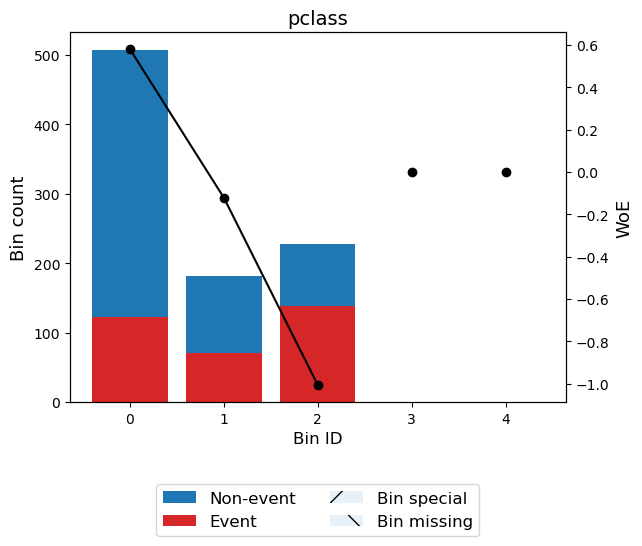

In [28]:
disc_pclass = utils.CustomDiscretizer(variable='pclass', dtype='categorical')
X_train['pclass_d'] = disc_pclass.fit_transform(X_train, y_train)
display(disc_pclass.binning_table.build())
disc_pclass.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[male],592,0.646288,486,106,0.179054,0.953276,0.486674,0.058631
1,[female],324,0.353712,99,225,0.694444,-1.390474,0.709875,0.082213
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,916,1.000000,585,331,0.361354,,1.196549,0.140843


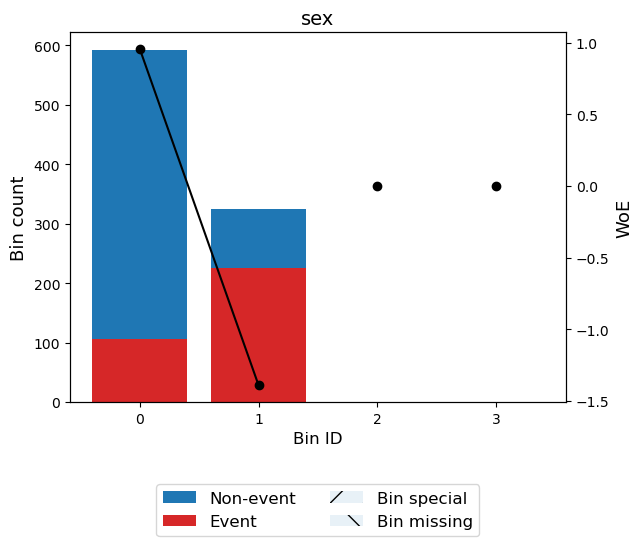

In [29]:
disc_sex = utils.CustomDiscretizer(variable='sex', dtype='categorical')
X_train['sex_d'] = disc_sex.fit_transform(X_train, y_train)
display(disc_sex.binning_table.build())
disc_sex.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Q],90,0.098253,62,28,0.311111,0.225436,0.004822,0.000602
1,[S],638,0.696507,438,200,0.313480,0.214408,0.030979,0.003865
2,[C],187,0.204148,85,102,0.545455,-0.751815,0.122439,0.014954
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,1,0.001092,0,1,0.000000,0.0,0.000000,0.000000
Totals,,916,1.000000,585,331,0.361354,,0.158241,0.019421


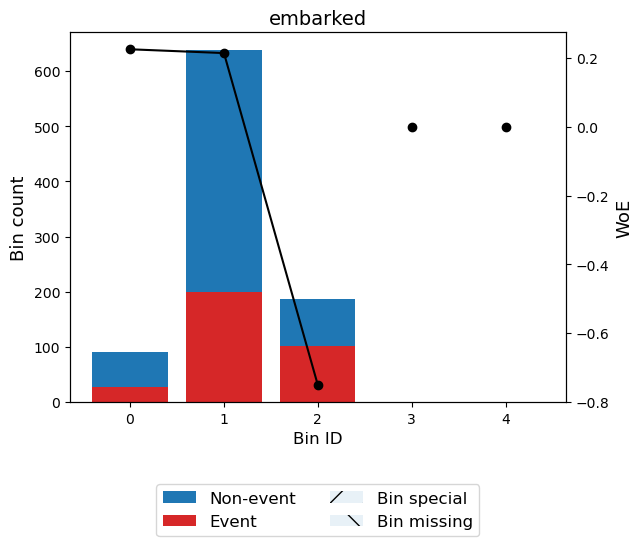

In [30]:
disc_embarked = utils.CustomDiscretizer(variable='embarked', dtype='categorical')
X_train['embarked_d'] = disc_embarked.fit_transform(X_train, y_train)
display(disc_embarked.binning_table.build())
disc_embarked.binning_table.plot()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Don, Jonkheer, Major, Rev, Mr]",540,0.589520,460,80,0.148148,1.179706,0.642507,0.075958
1,"[Master, Dr, Ms]",51,0.055677,26,25,0.490196,-0.530273,0.016483,0.002037
2,"[Miss, Col]",187,0.204148,69,118,0.631016,-1.106072,0.263850,0.031397
3,"[Mrs, Lady, Mlle, Mme, Sir]",137,0.149563,30,107,0.781022,-1.841125,0.500751,0.055024
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,1,0.001092,0,1,0.000000,0.0,0.000000,0.000000
Totals,,916,1.000000,585,331,0.361354,,1.423590,0.164415


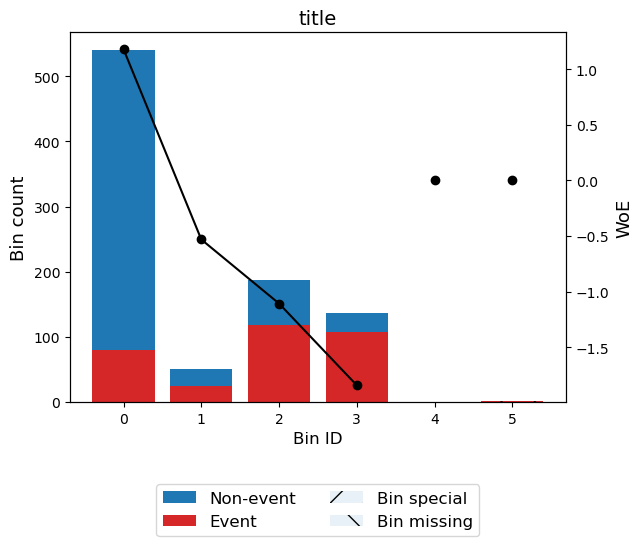

In [31]:
disc_title = utils.CustomDiscretizer(variable='title', dtype='categorical')
X_train['title_d'] = disc_title.fit_transform(X_train, y_train)
display(disc_title.binning_table.build())
disc_title.binning_table.plot()

In [32]:
X_train.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title,pclass_d,sex_d,embarked_d,title_d
1214,3,male,NaN,0,0,NaN,S,Mr,0.579729,0.953276,0.214408,1.179706
677,3,male,26.0,0,0,NaN,S,Mr,0.579729,0.953276,0.214408,1.179706
534,2,female,19.0,0,0,NaN,S,Miss,-0.122643,-1.390474,0.214408,-1.106072
1174,3,female,NaN,8,2,NaN,S,Miss,0.579729,-1.390474,0.214408,-1.106072
864,3,female,28.0,0,0,NaN,S,Miss,0.579729,-1.390474,0.214408,-1.106072


In [33]:
X_test = preprocessor.fit_transform(X_test)
X_test.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
1148,3,male,35.0,0,0,NaN,S,Mr
1049,3,male,20.0,1,1,NaN,C,Mr
982,3,male,NaN,0,0,NaN,S,Mr
808,3,male,NaN,0,0,NaN,S,Mr
1195,3,male,NaN,0,0,NaN,Q,Mr


In [34]:
X_test['pclass_d'] = disc_pclass.transform(X_test)
X_test['sex_d'] = disc_sex.transform(X_test)
X_test['embarked_d'] = disc_embarked.transform(X_test)
X_test['title_d'] = disc_title.transform(X_test)

In [35]:
vars = ['sibsp', 'parch', 'pclass_d', 'sex_d', 'embarked_d', 'title_d']
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train[vars], y_train)
y_preds_train = model_lr.predict_proba(X_train[vars])[:,1]
roc_auc_train = metrics.roc_auc_score(y_train, y_preds_train)
print(f"AUC Train: {roc_auc_train:0.2%}")

y_preds_test = model_lr.predict_log_proba(X_test[vars])[:,1]
roc_auc_test = metrics.roc_auc_score(y_test, y_preds_test)
print(f"AUC Test: {roc_auc_test:0.2%}")

AUC Train: 84.13%
AUC Test: 85.63%


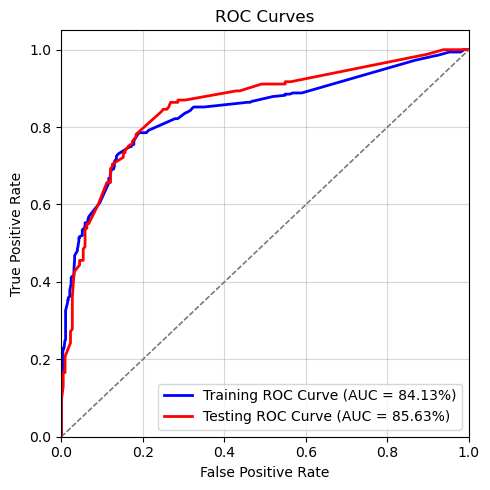

X_train (N) = 916
X_test (N) = 393


In [39]:
# Calculate ROC curve for training and test data
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_preds_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_preds_test)

# Plot ROC curve for training data
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {roc_auc_train:.2%})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot ROC curve for testing data
# plt.figure()
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Testing ROC Curve (AUC = {roc_auc_test:.2%})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Testing Data')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"X_train (N) = {X_train.shape[0]:,.0f}")
print(f"X_test (N) = {X_test.shape[0]:,.0f}")

### Create machine learning pipline

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1),
                                                    df['survived'],
                                                    test_size=0.2,
                                                    random_state=42)

In [89]:
preprocessor = FunctionTransformer(preprocessing)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train['pclass'] = X_train['pclass'].astype(int)
X_test['pclass'] = X_test['pclass'].astype(int)

In [90]:
X_train.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
772,3,male,17.0,0,0,NaN,S,Mr
543,2,male,36.0,0,0,NaN,S,Mr
289,1,female,18.0,0,2,E,S,Miss
10,1,male,47.0,1,0,C,C,Col
147,1,male,NaN,0,0,NaN,S,Mr


In [91]:
X_test.head()

,pclass,sex,age,sibsp,parch,cabin,embarked,title
1148,3,male,35.0,0,0,NaN,S,Mr
1049,3,male,20.0,1,1,NaN,C,Mr
982,3,male,NaN,0,0,NaN,S,Mr
808,3,male,NaN,0,0,NaN,S,Mr
1195,3,male,NaN,0,0,NaN,Q,Mr


In [92]:
from feature_engine.encoding import OrdinalEncoder

imputation_dict = {
    "sex": "Missing",
    "cabin": "Missing",
    "embarked": "Missing",
    "title": "Missing"
}

X_train.fillna(imputation_dict, inplace=True)
X_test.fillna(imputation_dict, inplace=True)

ordinal_enc = OrdinalEncoder(
    encoding_method="arbitrary",
    variables=['sex', 'cabin', 'embarked', 'title'],
)

ordinal_enc.fit(X_train)

X_train.shape, X_test.shape

((1047, 8), (262, 8))

In [93]:
ordinal_enc.encoder_dict_

{'sex': {'male': 0, 'female': 1},
 'cabin': {'Missing': 0,
  'E': 1,
  'C': 2,
  'B': 3,
  'A': 4,
  'F': 5,
  'D': 6,
  'G': 7,
  'T': 8},
 'embarked': {'S': 0, 'C': 1, 'Q': 2, 'Missing': 3},
 'title': {'Mr': 0,
  'Miss': 1,
  'Col': 2,
  'Master': 3,
  'Mrs': 4,
  'Rev': 5,
  'Sir': 6,
  'Mme': 7,
  'Don': 8,
  'Major': 9,
  'Mlle': 10,
  'Dr': 11,
  'Jonkheer': 12,
  'Lady': 13,
  'Missing': 14,
  'Ms': 15}}

In [94]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) title.
  warnings.warn(


In [95]:
display(X_train.head())
display(X_test.head())

,pclass,sex,age,sibsp,parch,cabin,embarked,title
772,3,0,17.0,0,0,0,0,0
543,2,0,36.0,0,0,0,0,0
289,1,1,18.0,0,2,1,0,1
10,1,0,47.0,1,0,2,1,2
147,1,0,NaN,0,0,0,0,0


,pclass,sex,age,sibsp,parch,cabin,embarked,title
1148,3,0,35.0,0,0,0,0,0.0
1049,3,0,20.0,1,1,0,1,0.0
982,3,0,NaN,0,0,0,0,0.0
808,3,0,NaN,0,0,0,0,0.0
1195,3,0,NaN,0,0,0,2,0.0


In [99]:
from xgboost import XGBClassifier

params = {
    'n_estimators': 300,
    'learning_rate': 0.01,
    'max_depth': 4
}

model_02 = XGBClassifier(**params, random_state=42)
model_02.fit(X_train, y_train)

y_preds_train = model_02.predict_proba(X_train)[:,1]
roc_auc_train = metrics.roc_auc_score(y_train, y_preds_train)
print(f"AUC Train: {roc_auc_train:0.2%}")

y_preds_test = model_02.predict_proba(X_test)[:,1]
roc_auc_test = metrics.roc_auc_score(y_test, y_preds_test)
print(f"AUC Test: {roc_auc_test:0.2%}")

AUC Train: 90.25%
AUC Test: 86.45%


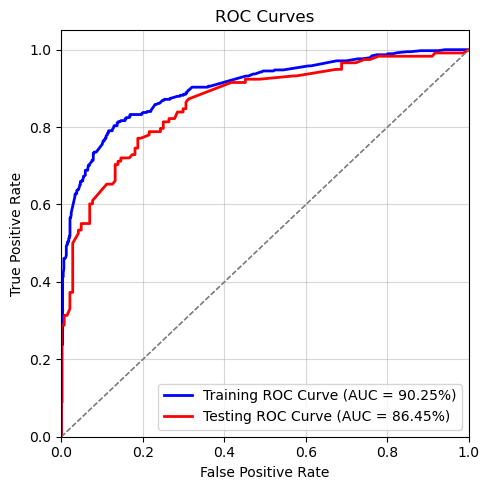

X_train (N) = 1,047
X_test (N) = 262


In [100]:
# Calculate ROC curve for training and test data
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_preds_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_preds_test)

# Plot ROC curve for training data
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {roc_auc_train:.2%})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot ROC curve for testing data
# plt.figure()
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Testing ROC Curve (AUC = {roc_auc_test:.2%})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Testing Data')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"X_train (N) = {X_train.shape[0]:,.0f}")
print(f"X_test (N) = {X_test.shape[0]:,.0f}")

In [61]:
# Create a pipeline with Preprocessor, CustomDiscretizer and LogisticRegression
pipeline = Pipeline([
    # ('preprocessing', FunctionTransformer(preprocessing)),
    ('discretizer_cat', utils.CustomDiscretizer(variables=['pclass', 'sex', 'embarked', 'title', 'cabin'],
                                            dtype='categorical', 
                                            max_n_bins=10, 
                                            min_bin_size=0.05)),
    # ('discretizer_num', utils.CustomDiscretizer(variables=['age', 'sibsp', 'parch'],
    #                                         dtype='numerical',
    #                                         max_n_bins=5, 
    #                                         min_bin_size=0.05)),
    ('classifier', LogisticRegression(random_state=42))
])

In [62]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_train)

# Evaluate the accuracy
accuracy = metrics.accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.8/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


ValueError: at least one array or dtype is required